In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e5/sample_submission.csv
/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')
submission = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")

In [4]:
df.head()

id     Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
0   0    male   36   189.0    82.0      26.0       101.0       41.0     150.0
1   1  female   64   163.0    60.0       8.0        85.0       39.7      34.0
2   2  female   51   161.0    64.0       7.0        84.0       39.8      29.0
3   3    male   20   192.0    90.0      25.0       105.0       40.7     140.0
4   4  female   38   166.0    61.0      25.0       102.0       40.6     146.0

In [5]:
test.head()

id     Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
0  750000    male   45   177.0    81.0       7.0        87.0       39.8
1  750001    male   26   200.0    97.0      20.0       101.0       40.5
2  750002  female   29   188.0    85.0      16.0       102.0       40.4
3  750003  female   39   172.0    73.0      20.0       107.0       40.6
4  750004  female   30   173.0    67.0      16.0        94.0       40.5

In [6]:
#deleting duplicate values
# key_columns = ["Sex", "Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp", "Calories"]

# # Keep only rows that do NOT have any duplicates in the key columns
# df = df[~df.duplicated(subset=key_columns, keep=False)]
# df.shape

Data Types:
 id              int64
Sex            object
Age             int64
Height        float64
Weight        float64
Duration      float64
Heart_Rate    float64
Body_Temp     float64
Calories      float64
dtype: object


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


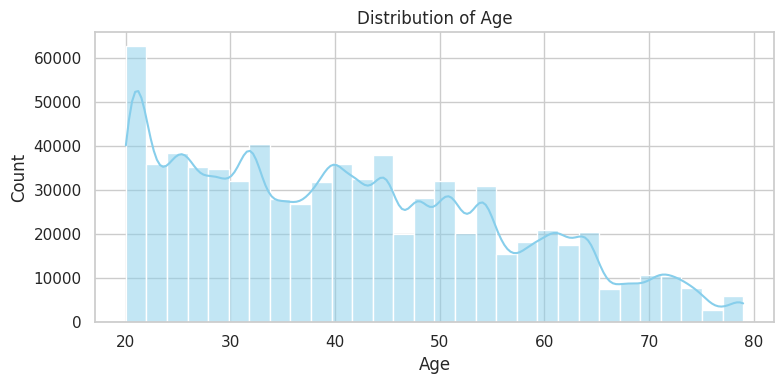

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


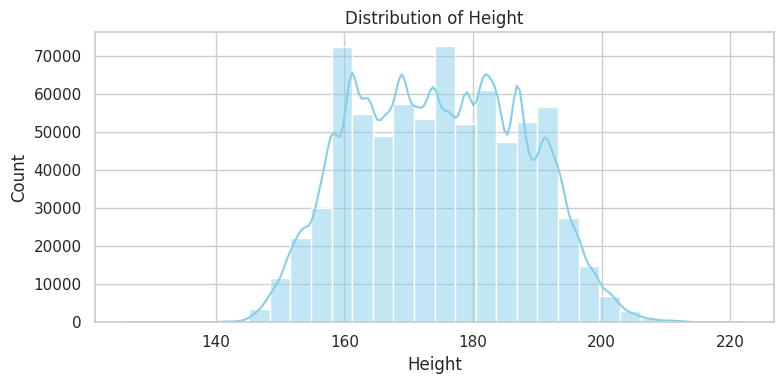

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


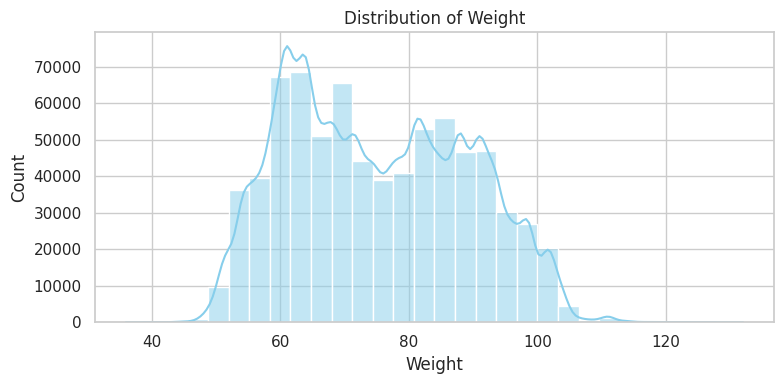

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


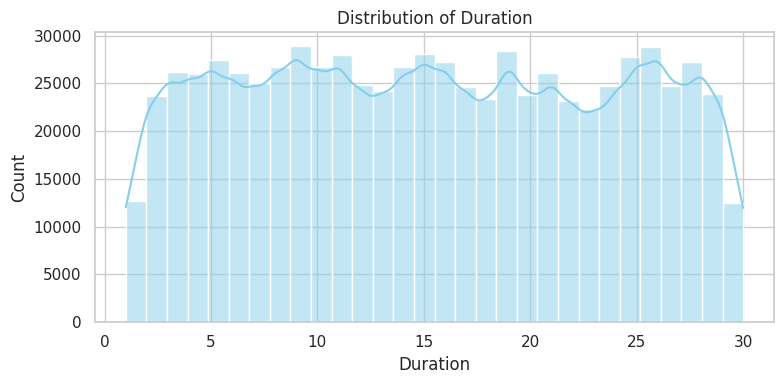

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


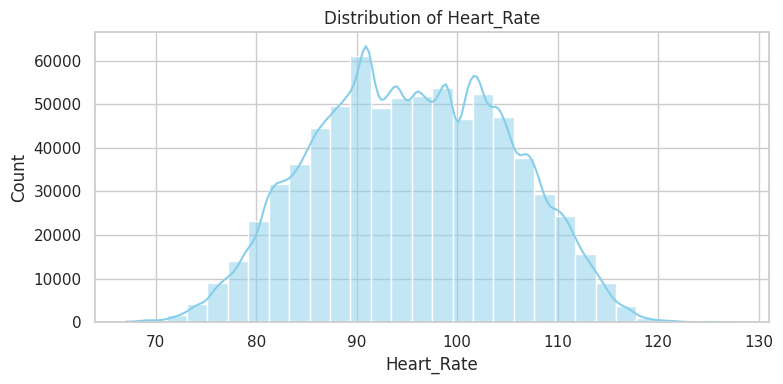

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


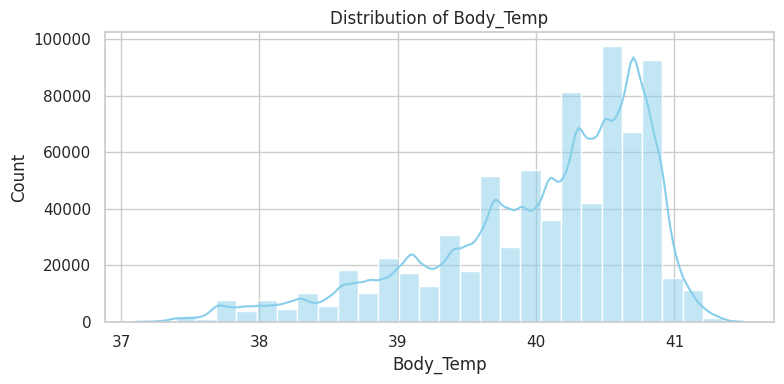

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


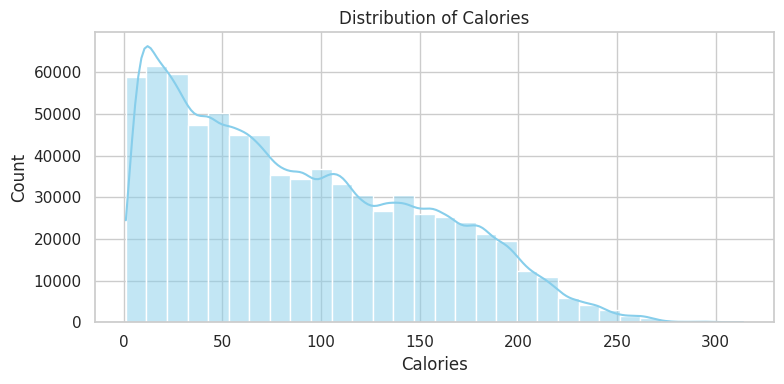

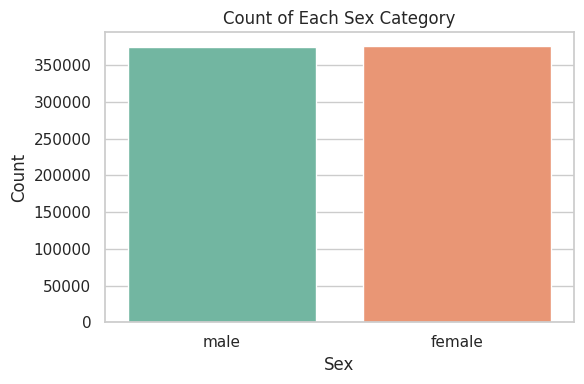

In [7]:
#to check the distribution of variables
sns.set(style="whitegrid")

# -------------------------------
# 1. Check for data types
# -------------------------------
print("Data Types:\n", df.dtypes)

# -------------------------------
# 2. Plot Distributions: Numerical Columns
# -------------------------------
numerical_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30, color="skyblue")
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# -------------------------------
# 3. Plot Distribution: Categorical Column (Sex)
# -------------------------------
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Sex', palette='Set2')
plt.title('Count of Each Sex Category')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


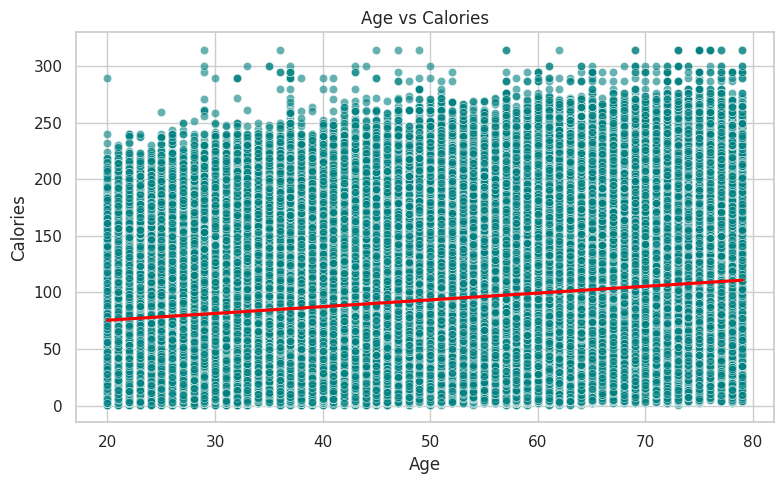

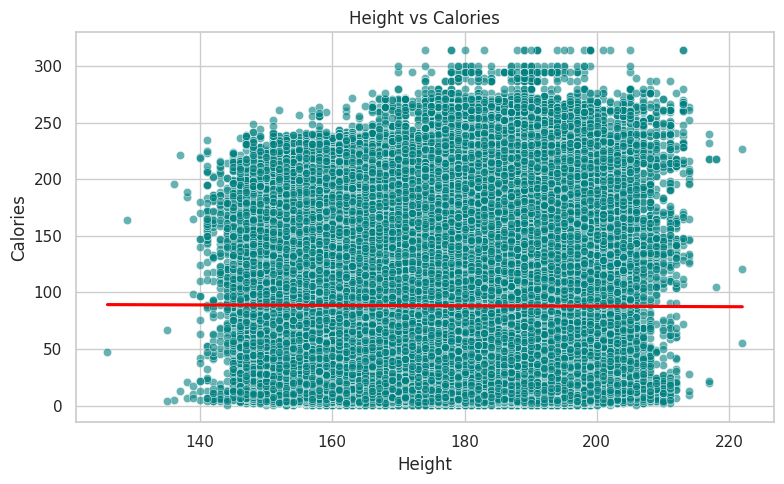

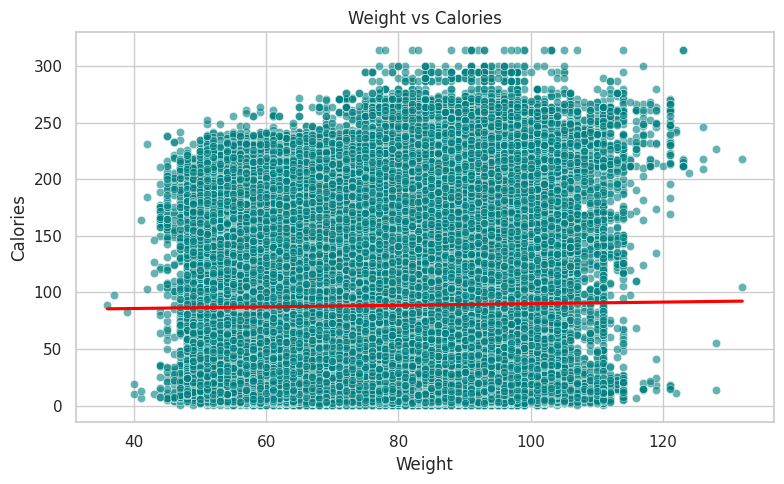

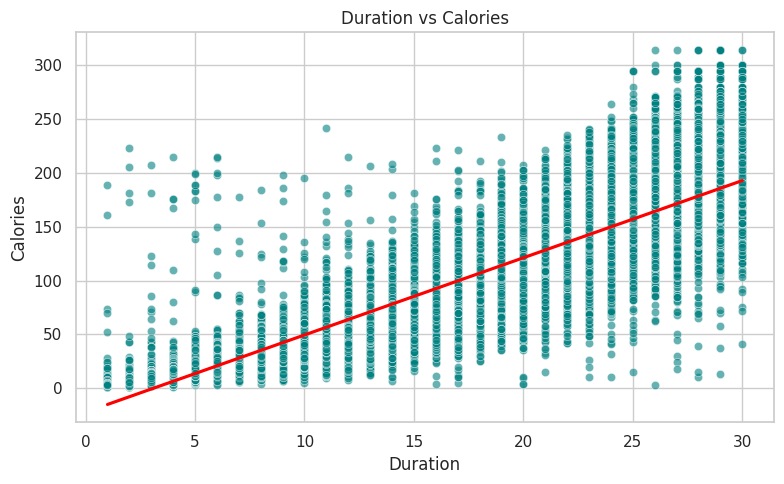

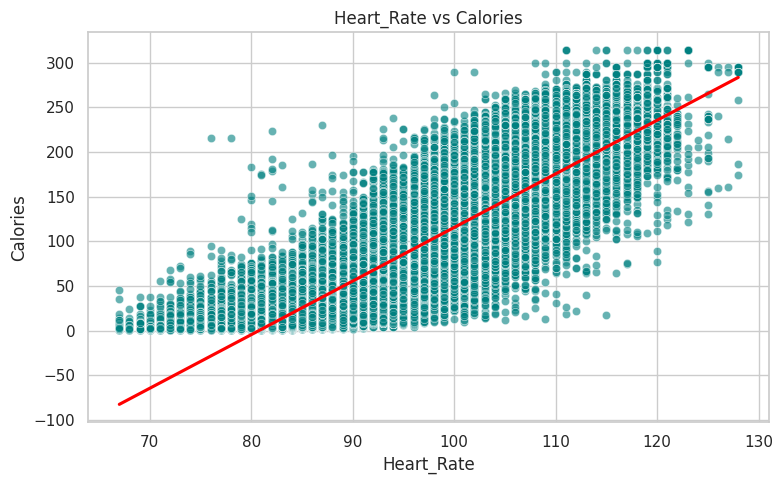

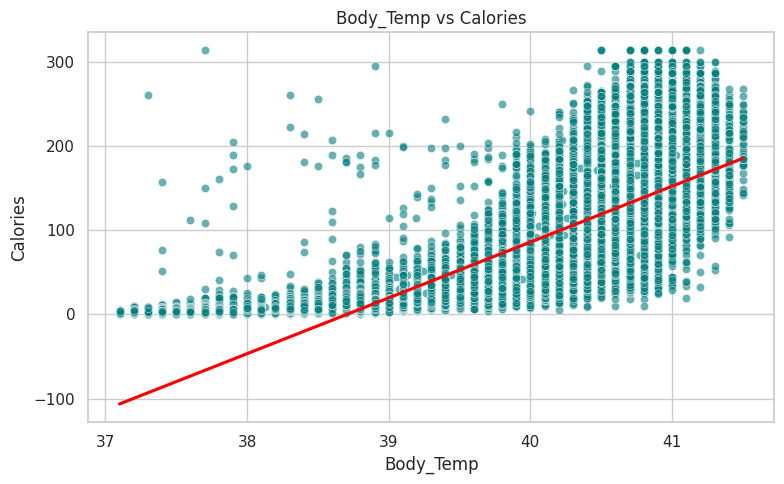

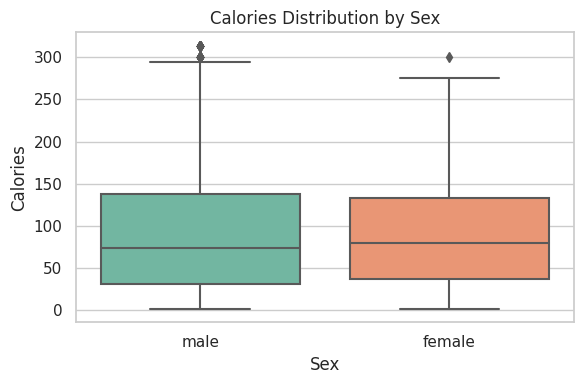

In [8]:
#to find any particular relation with Calories
# Set style
sns.set(style="whitegrid")

# -------------------------------
# 1. Scatter plots: Numerical vs Calories
# -------------------------------
numerical_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

for col in numerical_cols:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=col, y='Calories', color="teal", alpha=0.6)
    sns.regplot(data=df, x=col, y='Calories', scatter=False, color="red")  # trend line
    plt.title(f'{col} vs Calories')
    plt.xlabel(col)
    plt.ylabel('Calories')
    plt.tight_layout()
    plt.show()

# -------------------------------
# 2. Box plot: Categorical ('Sex') vs Calories
# -------------------------------
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Sex', y='Calories', palette="Set2")
plt.title('Calories Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Calories')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

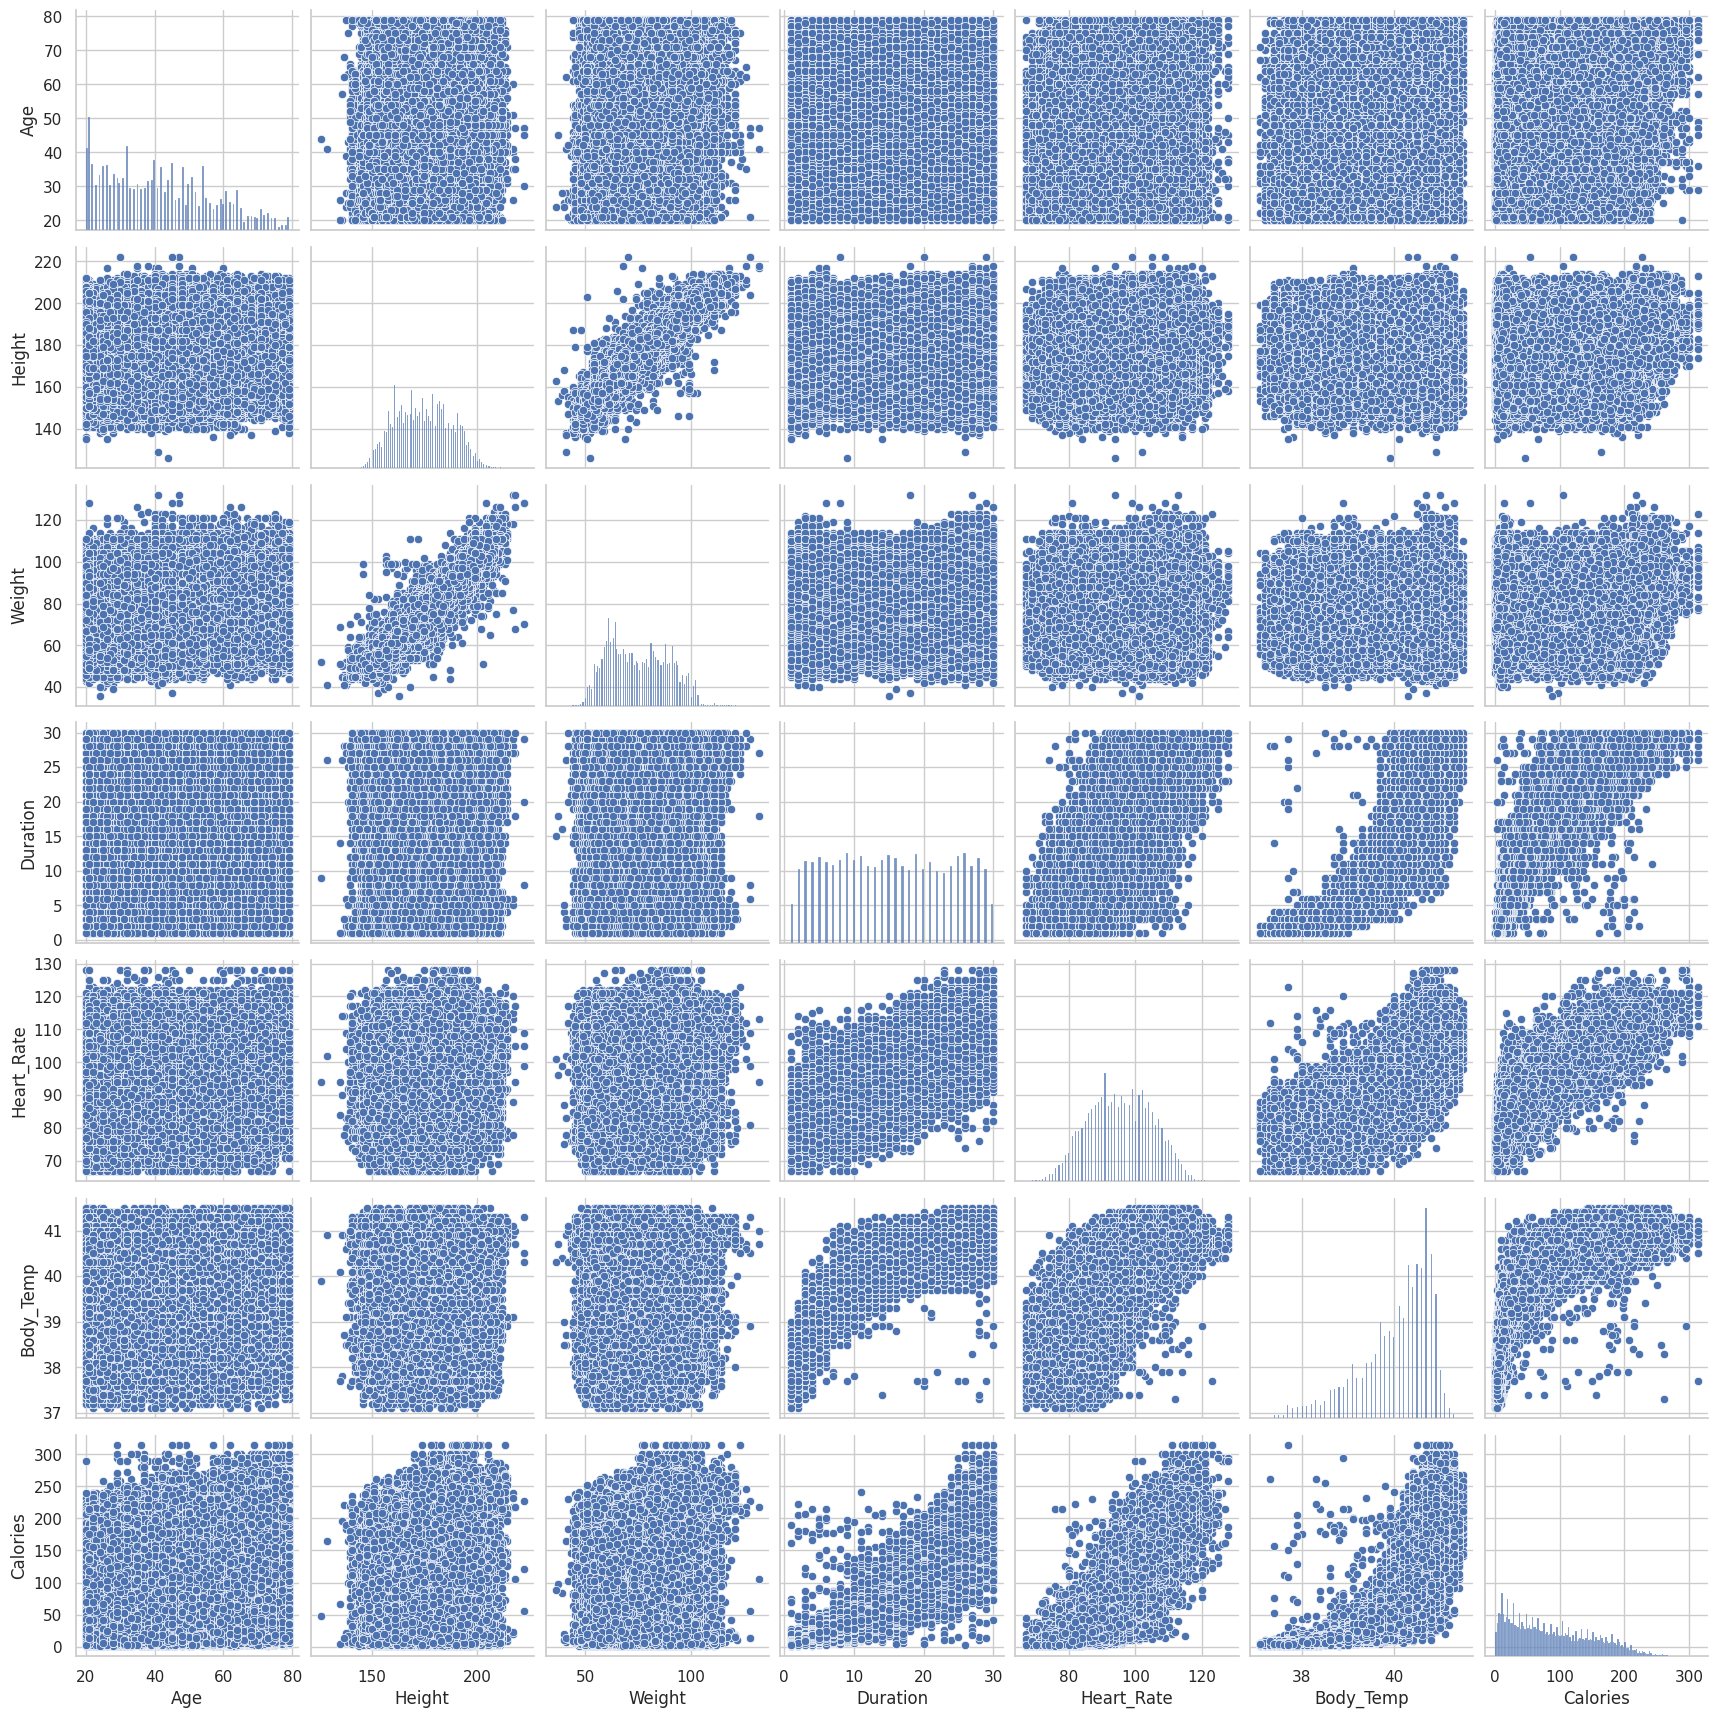

In [9]:
# Pairplot to visualize relationships between features
numerical_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']
sns.pairplot(df[numerical_cols])
plt.show()

In [10]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
test['Sex'] = label_encoder.transform(test['Sex'])

print(df.head())
print(test.head())

   id  Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
0   0    1   36   189.0    82.0      26.0       101.0       41.0     150.0
1   1    0   64   163.0    60.0       8.0        85.0       39.7      34.0
2   2    0   51   161.0    64.0       7.0        84.0       39.8      29.0
3   3    1   20   192.0    90.0      25.0       105.0       40.7     140.0
4   4    0   38   166.0    61.0      25.0       102.0       40.6     146.0
       id  Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp
0  750000    1   45   177.0    81.0       7.0        87.0       39.8
1  750001    1   26   200.0    97.0      20.0       101.0       40.5
2  750002    0   29   188.0    85.0      16.0       102.0       40.4
3  750003    0   39   172.0    73.0      20.0       107.0       40.6
4  750004    0   30   173.0    67.0      16.0        94.0       40.5


In [11]:
# Feature Engineering: Create cross terms between numerical features

numerical_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
def add_feature_cross_terms(df, features):
    df_new = df.copy()
    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            name = f"{features[i]}_x_{features[j]}"
            df_new[name] = df_new[features[i]] * df_new[features[j]]
    
    df_new["duration_heart_rate_var"] = df[["Duration", "Heart_Rate"]].var(axis=1)
    df_new["duration_body_temp_var"] = df[["Duration", "Body_Temp"]].var(axis=1)
    df_new["heart_rate_body_temp_var"] = df[["Heart_Rate", "Body_Temp"]].var(axis=1)
        
    return df_new

df = add_feature_cross_terms(df, numerical_cols)
test = add_feature_cross_terms(test, numerical_cols)

In [12]:
df.shape

(750000, 27)

In [13]:
test.shape

(250000, 26)

In [14]:
# Prepare training and testing data
X = df.drop(columns=["id", "Calories"])
y = np.log1p(df["Calories"])  # log-transform the target
X_test = test.drop(columns=["id"])

In [15]:
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros(len(df))
pred = np.zeros(len(test))

for i, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    print(f"\n{'#' * 10} Fold {i+1} {'#' * 10}")

    x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    x_valid, y_valid = X.iloc[valid_idx], y.iloc[valid_idx]

    model = XGBRegressor(
        max_depth=10,
        colsample_bytree=0.7,
        subsample=0.9,
        n_estimators=2000,
        learning_rate=0.02,
        gamma=0.01,
        max_delta_step=2,
        early_stopping_rounds=100,
        eval_metric="rmse",
        enable_categorical=True,
        tree_method="hist"  # ✅ Use CPU-based training
    )

    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=100)

    oof[valid_idx] = model.predict(x_valid)
    pred += model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_valid, oof[valid_idx]))
    print(f"Fold {i+1} RMSE: {rmse:.4f}")


########## Fold 1 ##########
[0]	validation_0-rmse:0.94438
[100]	validation_0-rmse:0.14160
[200]	validation_0-rmse:0.06230
[300]	validation_0-rmse:0.05971
[400]	validation_0-rmse:0.05965
[477]	validation_0-rmse:0.05966
Fold 1 RMSE: 0.0596

########## Fold 2 ##########
[0]	validation_0-rmse:0.94681
[100]	validation_0-rmse:0.14250
[200]	validation_0-rmse:0.06338
[300]	validation_0-rmse:0.06075
[400]	validation_0-rmse:0.06067
[488]	validation_0-rmse:0.06068
Fold 2 RMSE: 0.0607

########## Fold 3 ##########
[0]	validation_0-rmse:0.94544
[100]	validation_0-rmse:0.14158
[200]	validation_0-rmse:0.06235
[300]	validation_0-rmse:0.05975
[400]	validation_0-rmse:0.05966
[489]	validation_0-rmse:0.05967
Fold 3 RMSE: 0.0597

########## Fold 4 ##########
[0]	validation_0-rmse:0.94394
[100]	validation_0-rmse:0.14117
[200]	validation_0-rmse:0.06255
[300]	validation_0-rmse:0.06008
[400]	validation_0-rmse:0.06002
[472]	validation_0-rmse:0.06003
Fold 4 RMSE: 0.0600

########## Fold 5 ##########
[0]	valida

In [16]:
# Average predictions from folds
pred /= FOLDS

# Final validation score
final_rmse = np.sqrt(mean_squared_error(y, oof))
print(f"\n✅ Final CV RMSE: {final_rmse:.4f}")

# Exponentiate and clip predictions
y_preds = np.expm1(pred)
y_preds = np.clip(y_preds, 1, 314)

# Save submission
submission["Calories"] = y_preds
submission.to_csv("submission.csv", index=False)
submission.head()


✅ Final CV RMSE: 0.0600


id    Calories
0  750000   27.428770
1  750001  107.520764
2  750002   87.566314
3  750003  126.342334
4  750004   75.814863